## Importations de package

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
from scipy import ndimage

## Gradient morphologique

Text(0.5, 1.0, 'Gradient morphologique')

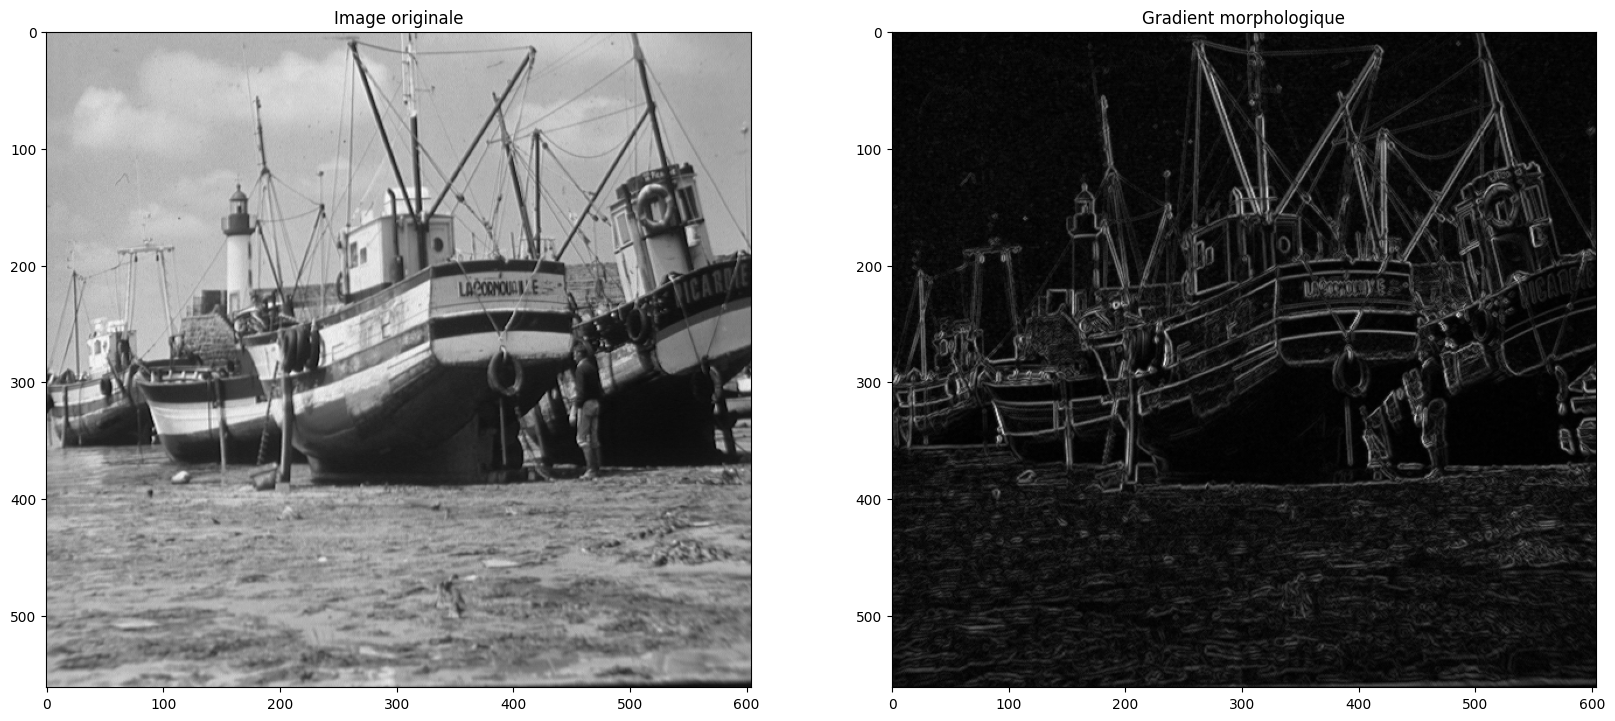

In [30]:
img = io.imread('images/bat.tif')



def gradmorpho(img):

    se = morpho.disk(1)
    morpho_grad = morpho.dilation(img,se) - morpho.erosion(img, se)

    return morpho_grad

grad_morpho = gradmorpho(img)

fig,ax = plt.subplots(1,2,figsize = (20,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(grad_morpho,cmap = "gray")
ax[1].set_title('Gradient morphologique')


## Cellules hexagonales

In [31]:
def calcul_hexa_centers(img,taille):
    colonnes, lignes = img.size
    hexa_centers = []
    p_horizontal=3*taille*0.5
    p_vertical=np.sqrt(3)*taille
    I = int(colonnes/p_horizontal) + 2 #I est le nombre de centres par ligne
    J = int(lignes/p_vertical) + 2 #J est le nombre de centres par colonne
    for i in range(I):
        for j in range(J):
            if i%2==0:
                hexa_centers.append((int(i*p_horizontal) ,int(j*p_vertical)))
            else:
                hexa_centers.append((int(i*p_horizontal),int((j*p_vertical)+p_vertical/2)))
    return hexa_centers

"""
hexa_centers = calcul_hexa_centers(img,10)
lignes, colonnes = img.shape
img_test = np.zeros((lignes,colonnes))+255
for center in hexa_centers:
    #if center[0]<lignes and center[1]<colonnes:
    img_test[center[0]][center[1]] = 0
plt.imshow(img_test,cmap='gray')
print(hexa_centers)
#hexa_contours = np.zeros((lignes,colonnes,1))
"""


"\nhexa_centers = calcul_hexa_centers(img,10)\nlignes, colonnes = img.shape\nimg_test = np.zeros((lignes,colonnes))+255\nfor center in hexa_centers:\n    #if center[0]<lignes and center[1]<colonnes:\n    img_test[center[0]][center[1]] = 0\nplt.imshow(img_test,cmap='gray')\nprint(hexa_centers)\n#hexa_contours = np.zeros((lignes,colonnes,1))\n"

In [32]:
def hexa_sommets(centre, t, rho):
    x,y = centre
    taille= t*rho
    return [(x+taille,y),
            (x+(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-(taille/2),y+(taille*np.sqrt(3)/2)),
            (x-taille,y),
            (x-(taille/2),y-(taille*np.sqrt(3)/2)),
            (x+(taille/2),y-(taille*np.sqrt(3)/2))
            ]


Text(0.5, 1.0, 'rho=0.9')

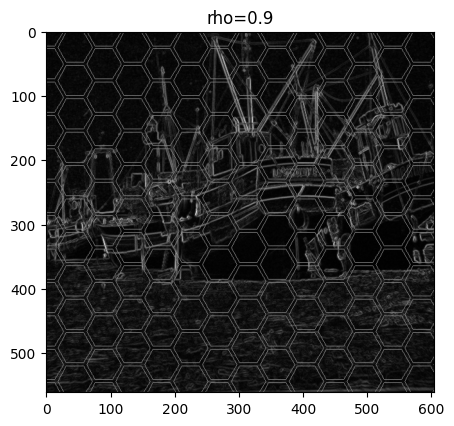

In [33]:
def hexagon_grid(img, taille, rho):
    img_grid = img.copy()
    draw = ImageDraw.Draw(img_grid)
    hexa_centers = calcul_hexa_centers(img,taille)

    for c in hexa_centers:
        p = hexa_sommets(c, taille, rho)
        draw.polygon((p),outline="gray")

    return img_grid

im = Image.fromarray(np.uint8(grad_morpho))
hexa = hexagon_grid(im,30,0.9)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(hexa, cmap='gray')
ax.set_title('rho=0.9')


## Sélection des marqueurs

Un point est dans l'hexagone s'il est dans le cercle inscrit de l'hexagone

In [34]:
def point_dans_hexagon(centre,point,taille):
    x,y = point[0]-centre[0],point[1]-centre[1]
    distance = math.sqrt((x**2)+(y**2))
    if distance <= np.sqrt(3)*taille/2:
        return True
    else:
        return False

Text(0.5, 1.0, 'Cellules')

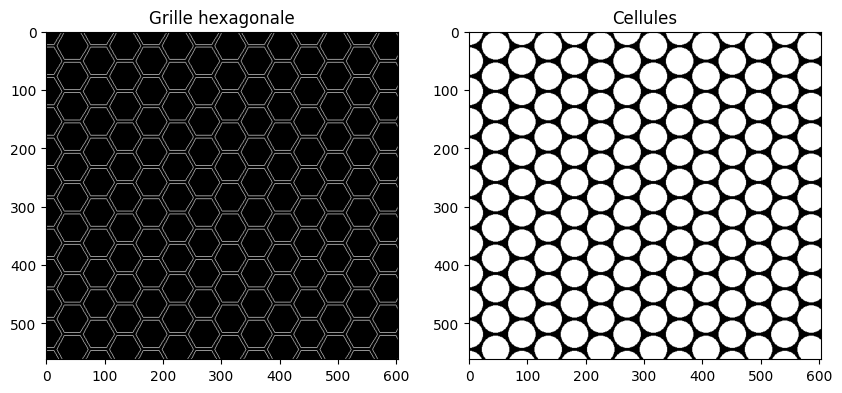

In [35]:
def extract_hex_points(centre,taille):
    square = []
    hex=[]
    for x in range(-taille-1,taille+1):
        for y in range(-taille-1,taille+1):
            square.append((centre[0]+x,centre[1]+y))
    for s in square:
        if(point_dans_hexagon(centre,s,taille)):
            hex.append(s)
    return hex

colonnes, lignes = im.size

img_check_hex_selection = Image.new(mode='L',size=im.size,color=0)
for c in calcul_hexa_centers(im,30):
    hexa_surface = extract_hex_points(c,int(30*0.9))
    for p in hexa_surface:
        if p[0]<colonnes and p[0]>=0 and p[1]<lignes and p[1]>=0:
            img_check_hex_selection.putpixel(p,255)

black_image = Image.new(mode='L',size=im.size,color=0)

img_hexagon_grid = hexagon_grid(black_image,30,0.9)

fig,ax = plt.subplots(1,2,figsize = (10,10))

ax[0].imshow(img_hexagon_grid,cmap='gray')
ax[0].set_title('Grille hexagonale')
ax[1].imshow(img_check_hex_selection,cmap = "gray")
ax[1].set_title('Cellules')


In [36]:
def extract_hex_grad(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    colonnes, lignes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<colonnes and p[1]>=0 and p[1]<lignes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    return grad_hex,grad_coord

s=[]
for c in calcul_hexa_centers(im,30):
    grad_val,grad_coord = extract_hex_grad(im,c,int(30*0.9))
    s.append((grad_val,grad_coord))

img_selection_grad_hex = Image.new(mode='L',size=im.size,color=0)

for g in s:
    for i in range(len(g[1])):
        val = g[0][i]
        coord = g[1][i]
        img_selection_grad_hex.putpixel(coord,val)

#img_selection_grad_hex.show()

Text(0.5, 1.0, 'Minima du gradient en blanc')

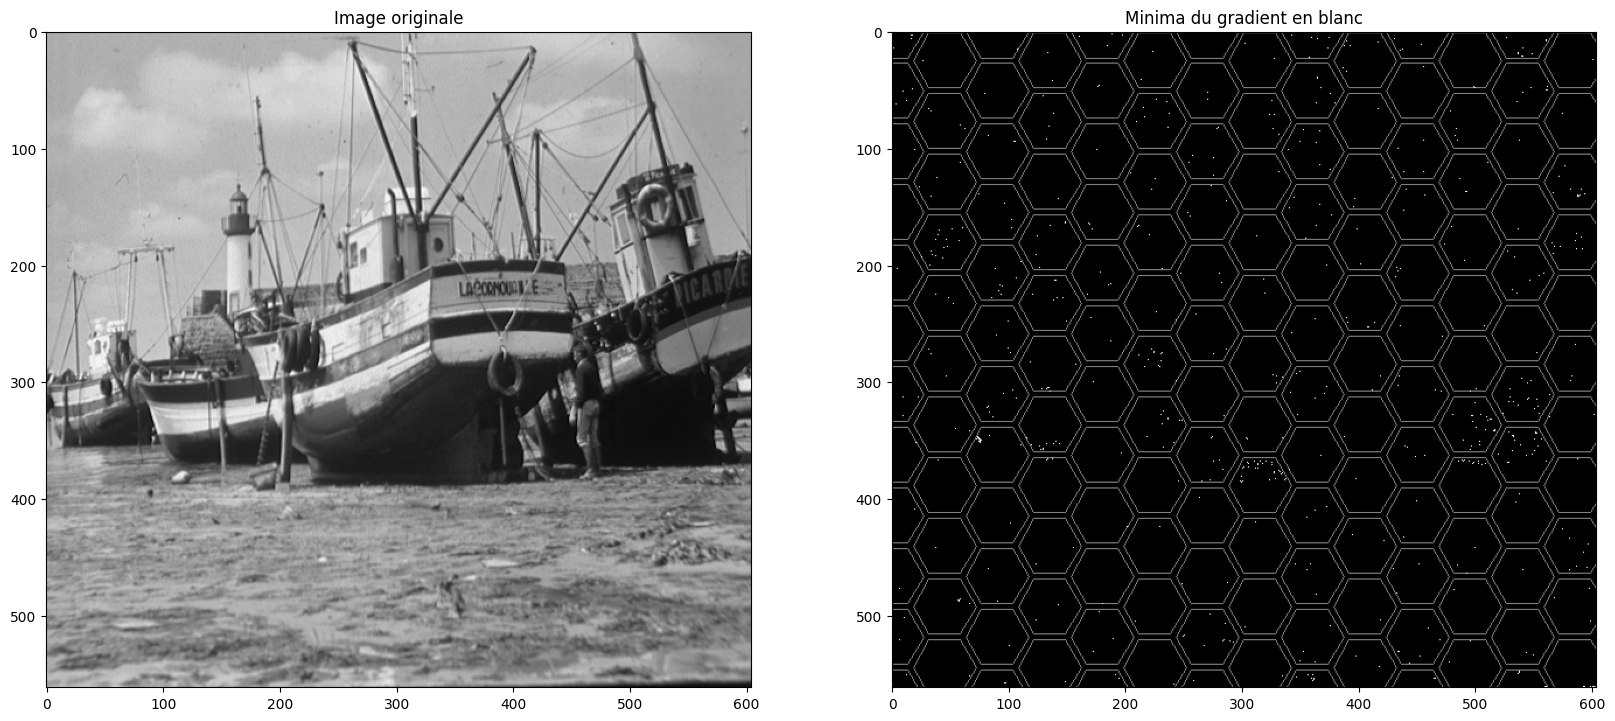

In [37]:
def extract_hex_grad_min(grad_im,c,taille):
    hex_points = extract_hex_points(c,taille)
    grad_hex = []
    grad_coord = []
    colonnes, lignes = grad_im.size
    for p in hex_points:
        if (p[0]>=0 and p[0]<colonnes and p[1]>=0 and p[1]<lignes):
            grad_hex.append(grad_im.getpixel((p[0],p[1])))
            grad_coord.append((p[0],p[1]))
    grad_hex = np.array(grad_hex)
    if len(grad_hex)>0:
        min_indices = np.where(grad_hex == grad_hex.min())[0]
        min_coord = [grad_coord[i] for i in min_indices]
        return min_coord
    else:
        return [c]

s=[]
for c in calcul_hexa_centers(im,30):
    grad_min = extract_hex_grad_min(im,c,int(30*0.9))
    s.append(grad_min)

colonnes, lignes = im.size

img_selection_marqueur = Image.new(mode='L',size=im.size,color=0)
img_selection_marqueur = hexagon_grid(Image.fromarray(np.uint8(img_selection_marqueur)),30,0.9)

for hexagon in s:
    for i in range(len(hexagon)):
        xy = hexagon[i]
        if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
            img_selection_marqueur.putpixel(xy,255)
fig,ax = plt.subplots(1,2,figsize = (20,15))

#img_selection_marqueur.show()
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Image originale')
ax[1].imshow(img_selection_marqueur,cmap = "gray")
ax[1].set_title('Minima du gradient en blanc')

Pour l'instant, le voisinage est équivalent à la 8-connexité.

In [38]:
def est_voisin(x_i,y_i,x_j,y_j):
    voisin = False
    if ((x_j==x_i+1) or(x_j==x_i-1) or (x_i==x_j)) and ((y_j==y_i+1) or y_j==y_i-1 or y_j==y_i):
        voisin = True
    return voisin

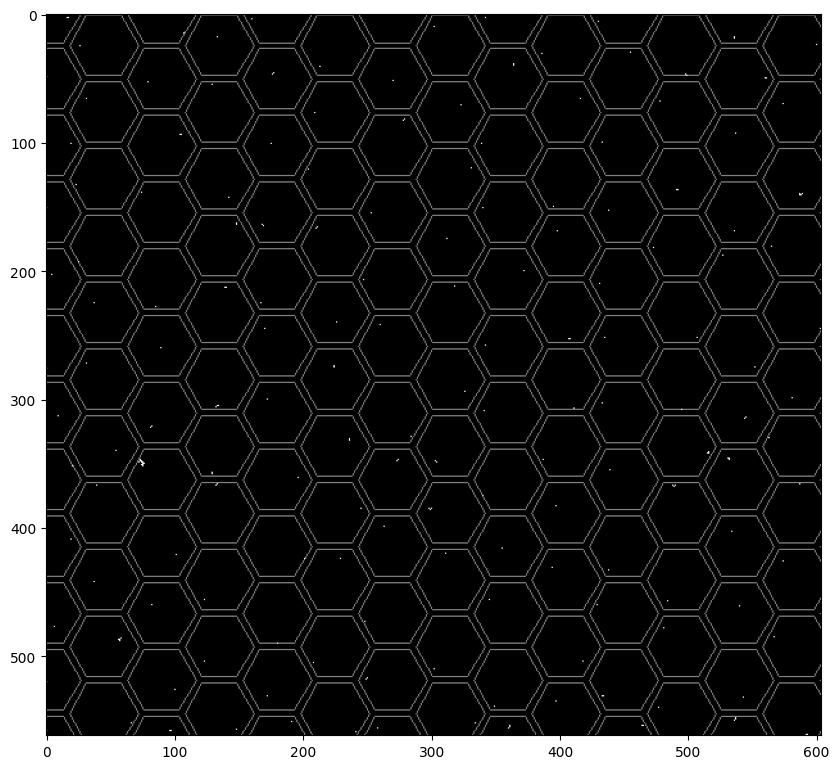

In [39]:
def selection_marqueurs(grad_im,taille,rho):
    marqueurs = []
    centres = calcul_hexa_centers(grad_im,taille)
    for c in centres:
        hex = extract_hex_grad_min(grad_im,c,int(rho*taille))
        comp = []
        while len(hex)>0:
            CC=[hex[0]]
            bl=[hex[0]]
            Attente=[]
            for s in hex:
                if s not in bl:
                    x_0,y_0 = hex[0]
                    x_s,y_s = s
                    if est_voisin(x_0,y_0,x_s,y_s):
                        Attente.append(s)
                        bl.append(s)
            while len(Attente)>0:
                sprime=Attente[0]
                for s in hex:
                    if s not in bl:
                        x_0,y_0 = sprime
                        x_s,y_s = s
                        if est_voisin(x_0,y_0,x_s,y_s):
                            Attente.append(s)
                            bl.append(s)
                Attente.remove(sprime)
                CC.append(sprime)
            comp.append(CC)
            for b in bl:
                hex.remove(b)
        max_surface = max(comp, key=len)
        marqueurs.append(max_surface)
    return marqueurs


s=selection_marqueurs(im,30,0.9)

new_temp_img = Image.new(mode="L",size=img_selection_marqueur.size,color=0)

temp_hexa = hexagon_grid(Image.fromarray(np.uint8(new_temp_img)),30,0.9)
colonnes,lignes = im.size
for grad_coord in s:
    for xy in grad_coord:
        if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
            temp_hexa.putpixel(xy,255)


#temp_hexa.show()
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(temp_hexa, cmap='gray')


## Carte des distances

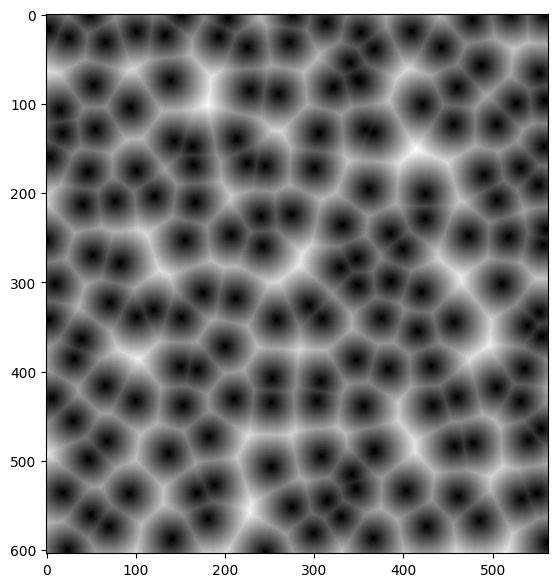

In [40]:
def binary_grad_min(im,taille,rho):
    s=selection_marqueurs(im,taille,rho)
    bin_img = np.ones((im.size))
    colonnes,lignes = im.size
    for grad_coord in s:
        for xy in grad_coord:
            if xy[0]<colonnes and xy[0]>=0 and xy[1]<lignes and xy[1]>=0:
                bin_img[xy[0]][xy[1]]=0
    return bin_img

carte_distance = binary_grad_min(im,30,0.9)
carte_distance = ndimage.distance_transform_edt(carte_distance)
carte_distance = Image.fromarray(np.uint8(carte_distance))

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(carte_distance, cmap='gray')


Text(0.5, 1.0, 'Gradient régularisé')

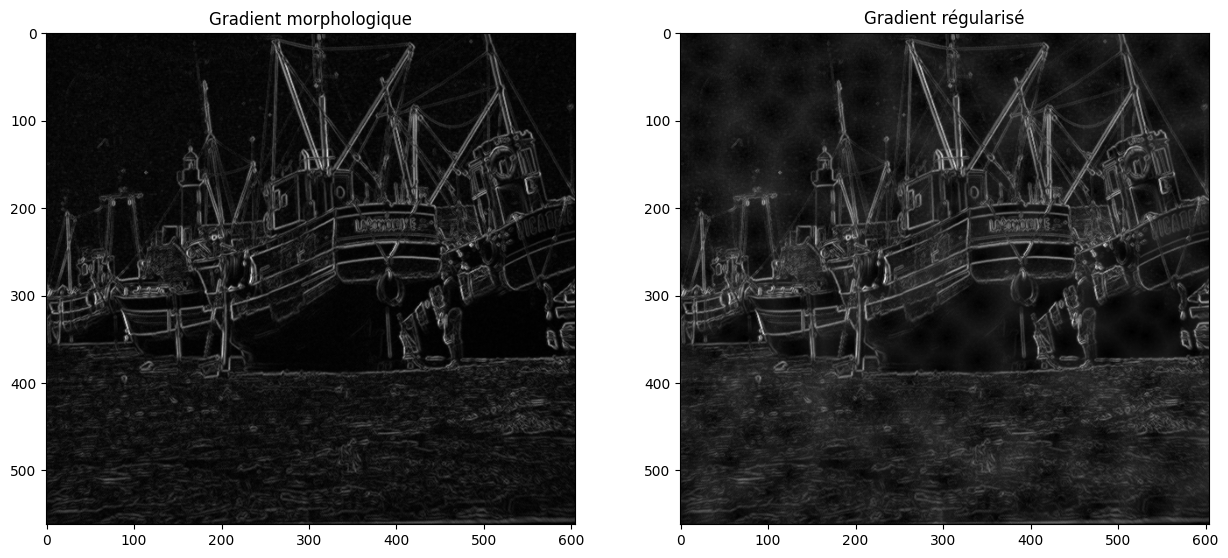

In [50]:
def regularisation_spatiale(grad_im,distance_carte,k,taille):
    colonnes, lignes = grad_im.size
    new_grad_im = Image.new(mode="L",size=(colonnes,lignes),color=0)
    for i in range(colonnes):
        for j in range(lignes):
            new_pixel = grad_im.getpixel((i,j))+(k*(2/taille)*distance_carte[i][j])
            new_grad_im.putpixel((i,j),int(new_pixel))
    return new_grad_im

carte_distance = binary_grad_min(im,30,0.9)
carte_distance = ndimage.distance_transform_edt(carte_distance)
grad_regularized = regularisation_spatiale(im,carte_distance,10,30)

fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(im, cmap='gray')
ax[0].set_title("Gradient morphologique")
ax[1].imshow(grad_regularized, cmap='gray')
ax[1].set_title("Gradient régularisé")

## Application du Watershed

In [56]:
colonnes,lignes = im.size
mark_img_binary = np.zeros((colonnes,lignes))

for c in calcul_hexa_centers(im,30):
    grad_min = extract_hex_grad_min(im,c,int(30*0.9))
    for g in grad_min:
        if g[0]<colonnes and g[0]>=0 and g[1]<lignes and g[1]>=0:
            mark_img_binary[g[0]][g[1]]=1

ws = watershed(grad_regularized, mark_img_binary,watershed_line = True)

AttributeError: shape